In [67]:
train_dataset_dir = '/home/noa_glaser/dataBig/train-1-2-4/train'
val_dataset_dir = '/home/noa_glaser/dataBig/train-1-2-4/val'
audio_dataset_dir = '/home/noa_glaser/dataBig/train-1-2-4-audio'
label_dataset_dir = train_dataset_dir
exp_name = 'ResNet34_LSTM_experiment' # roughly 3K videos
num_classes = 5 
num_partition = 10
batch_size = 16

In [2]:
# -*- coding: utf-8 -*- 

from __future__ import print_function, division

import pickle
import sys

import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
%matplotlib inline


from PIL import Image
import time
import copy
import shutil

## first, get the Images (path) and their labels (five personality traits)

In [13]:
def get_img_audio_label(dataset_dir,audio_dataset_dir,label_dataset_dir):
    """Returns a list of 
filenames and inferred class names.
    Args:
    dataset_dir: A directory containing a set of subdirectories representing
      class names. Each subdirectory should contain PNG or JPG encoded images.
    Returns:
    A list of image file paths, relative to `dataset_dir` and the list of
    subdirectories, representing class names.
    """
   
    print("processing dataset: "+ dataset_dir)
    img_paths = [] 
    audio_paths=[]
    raw_movienames = []
    labels = []

    annotaion_filename = label_dataset_dir + "/annotation_training.pkl"
    
    with open(annotaion_filename, 'rb') as f:
        label_dicts = pickle.load(f, encoding='latin1') 

    for movie in os.listdir(dataset_dir):
        fileEnding ='_50uniform' #TODO: figure out how to make more general
        if fileEnding not in movie: continue #skip non-movie files
        raw_moviename = movie.replace(fileEnding,'.mp4')
        raw_movienames.append(raw_moviename)
        
        big_five = [label_dicts['extraversion'][raw_moviename], 
                    label_dicts['neuroticism'][raw_moviename],
                    label_dicts['agreeableness'][raw_moviename],
                    label_dicts['conscientiousness'][raw_moviename],
                    label_dicts['openness'][raw_moviename] ]
                    #label_dicts['interview'][raw_moviename]]
        labels.append(big_five)
        
        
        
        
        movie_path = os.path.join(dataset_dir, movie)
        mv_partitions = []
        p = 0
        all_imgs = os.listdir(movie_path)
        assert(len(all_imgs) >= num_partition)
        for i in range(num_partition):
            path = os.path.join(movie_path, all_imgs[i])
            try:
                open(path)
            except:
                print('image failed to open',path)
            mv_partitions.append(path)
        assert(len(mv_partitions)==num_partition)
        img_paths.append(mv_partitions)
        
        audiofeat_path = os.path.join(audio_dataset_dir,raw_moviename+'.wav.csv')
        try:
            open(audiofeat_path)
        except:
            print('image failed to open',path)
        audio_paths.append(audiofeat_path)
            
    
    return np.array(img_paths), np.array(audio_paths),np.array(labels), np.array(raw_movienames)



## use this if we need to split our dataset into train/val

In [4]:
#all_img_names, all_labels, all_movies = _get_imgname_and_moviename_and_labels( dataset_dir)  
#validation_size = 0.3
#num_validation = int(validation_size * len(all_img_names))

#all_img_names = np.array(all_img_names)
#all_labels = np.array(all_labels)
#all_movies = np.array(all_movies)
#training_filenames = all_img_names[num_validation:]
#validation_filenames = all_img_names[:num_validation]
#train_labels = all_labels[num_validation:]
#val_labels = all_labels[:num_validation]
#train_movies = all_movies[num_validation:]
#val_movies = all_movies[:num_validation]

## use this if we have seperated train/val dataset

In [14]:
train_img_paths,train_audio_paths, train_labels, train_movienames = get_img_audio_label(train_dataset_dir,audio_dataset_dir,label_dataset_dir)  
val_img_paths,val_audio_paths, val_labels, val_movienames = get_img_audio_label(val_dataset_dir,audio_dataset_dir,label_dataset_dir)  

processing dataset: /home/noa_glaser/dataBig/train-1-2-4/train
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/JBdLI6AhJrw.001.mp4.wav.csv
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/RgZTZIf8K8g.003.mp4.wav.csv
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/39o1zJFeM7E.004.mp4.wav.csv
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/tCnfvBwWVKw.002.mp4.wav.csv
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/m3z_a0l0FRk.000.mp4.wav.csv
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/Z5S5uGXkNuc.001.mp4.wav.csv
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/mhF4kYTlVUE.002.mp4.wav.csv
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/upgv7xmOb1I.005.mp4.wav.csv
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/S-e9-bW4seo.001.mp4.wav.csv
(11, 68)
wrong size /home/noa_glaser/dataBig/train-1-2-4-audio/48S9_KZvzVw.004.mp4.wav.csv
processing dataset: /home/n

## Data Loader. Data is normalized before feeding into model (as required by the pretrained model)

In [25]:
def default_img_loader(img_paths,transform):
    ten_img_tensor = []
    for path in img_paths:
        img = Image.open(path).convert('RGB')
        if transform is not None:
            img = transform(img)
        ten_img_tensor.append(img)
        
    return torch.cat(ten_img_tensor)
        

def default_audio_loader(path):
	return np.loadtxt(path,delimiter=',')

class VisualAudio(data.Dataset):
    def __init__(self,split,img_paths,audio_paths, movie_names,labels,transform=None,
                 img_loader=default_img_loader,audio_loader=default_audio_loader):
        if len(img_paths) != len(audio_paths) or len(audio_paths) == 0 or len(labels)!=len(audio_paths) :
            raise(RuntimeError("something is wrong with the data directory"))
                  
        self.split = split 
        self.img_paths = img_paths
        self.audio_paths = audio_paths
        self.movie_names = movie_names
        self.labels = labels
        self.transform = transform
        self.img_loader=img_loader
        self.audio_loader= audio_loader
        
    def __getitem__(self, index):
        img_paths, audio_paths,target = self.img_paths[index], self.audio_paths[index], self.labels[index]
        ten_img_tensor = self.img_loader(img_paths,self.transform)
        ten_audio = self.audio_loader(audio_paths)
        #return 30x224x224 , 10x68, 10 x 5
        
        assert(ten_img_tensor.size() == (30,256,256))
        
        return ten_img_tensor, ten_audio[:10,:], target

    def __len__(self):
        return len(self.img_paths)
    
        
        
    

In [26]:
from torchvision import  transforms

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(256),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

        
dsets = {}
dsets['train'] = VisualAudio('train',train_img_paths,train_audio_paths,  train_movienames ,train_labels,transform=data_transforms['train'] )
dsets['val'] = VisualAudio('val',val_img_paths,val_audio_paths,val_movienames,val_labels,transform=data_transforms['val'] )

dset_loaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,
                                               shuffle=True, num_workers=4) for x in ['train', 'val']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'val']}
dset_sizes

{'train': 2304, 'val': 576}

##  Some dataset examples (each batch is 16)

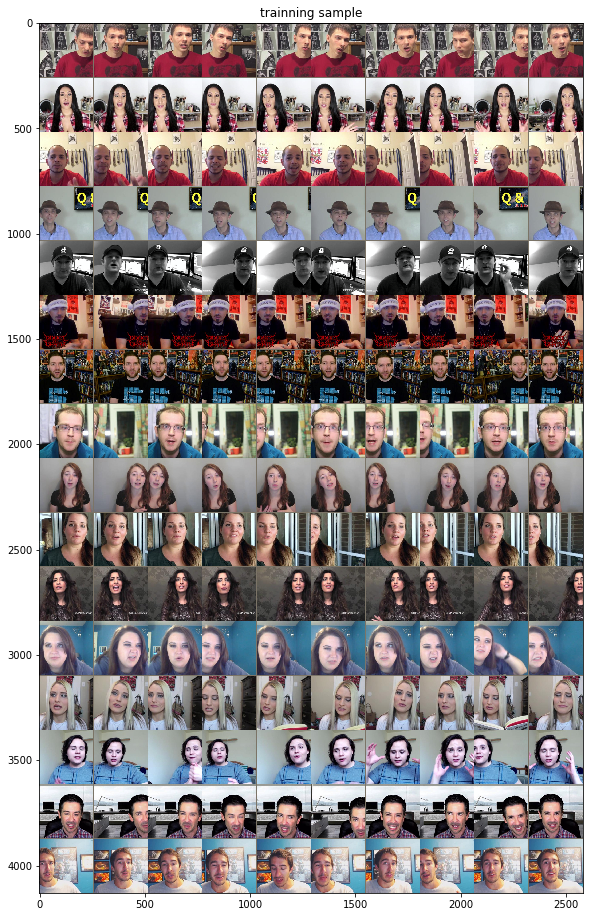

In [27]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
train_imgsamples,train_audiosamle,train_labelsample = next(iter(dset_loaders['train']))


train_unflattened_sample = train_imgsamples.view(-1,3,256,256)
# Make a grid from batch
plt.figure( figsize=(10, 16))
out = torchvision.utils.make_grid(train_unflattened_sample,nrow=10)
imshow(out, title='trainning sample')
plt.savefig('train_exp.png', bbox_inches='tight')

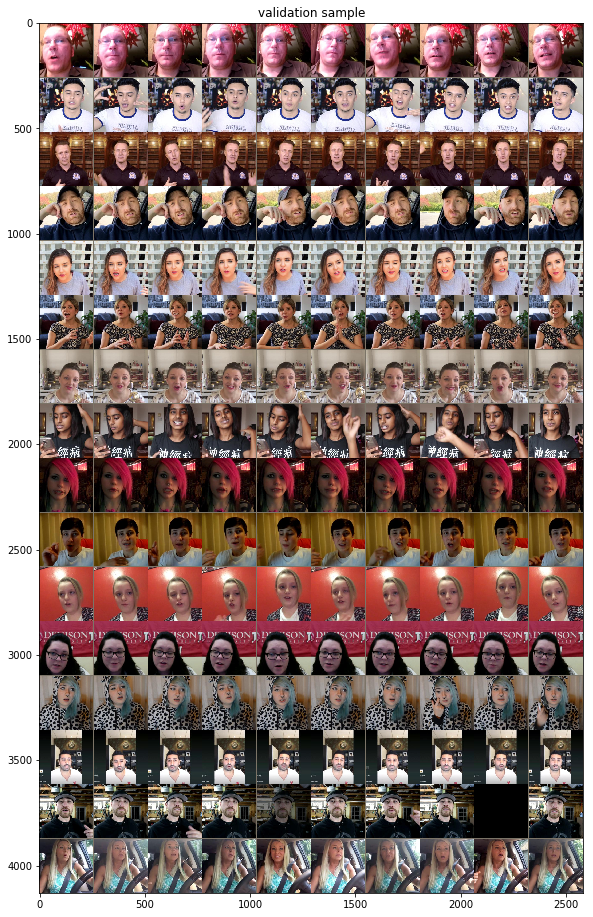

In [29]:
val_imgsamples,val_audiosamle,val_labelsample = next(iter(dset_loaders['val']))
val_unflattened_sample = val_imgsamples.view(-1,3,256,256)
# Make a grid from batch
plt.figure( figsize=(10, 16))
out2 = torchvision.utils.make_grid(val_unflattened_sample,nrow=10)
imshow(out2, title='validation sample')
plt.savefig('val_exp.png', bbox_inches='tight')

## Define Model

In [115]:
class AudioVisualLSTM(nn.Module):
    NUM_VID_FEATURES = 128
    NUM_AUDIO_FEATURES = 32
    NUM_LSTM_HIDDEN = 128
    NUM_PARTITIONS = 10
    NUM_CLASS = 5
    
    def __init__(self):        
        super(AudioVisualLSTM, self).__init__()
        self.audioBranch =  nn.Sequential(nn.Linear(68,32))
        #self.videoBranch = self._createVideoBranch()
        self.videoBranch = torchvision.models.resnet34(pretrained=True)
        for param in self.videoBranch.parameters():
            param.requires_grad = False   
        self.videoBranch.fc = nn.Linear(self.videoBranch.fc.in_features, self.NUM_VID_FEATURES)
        
        self.lstm = nn.LSTM(
            input_size=(self.NUM_VID_FEATURES+self.NUM_AUDIO_FEATURES),
            hidden_size=self.NUM_LSTM_HIDDEN,
            num_layers=1,
            bias=True,
            batch_first=True # input and output tensors provided as (batch, seq, feature)
            # can add dropout later
            )
        self.fc = nn.Linear(self.NUM_LSTM_HIDDEN,self.NUM_CLASS)
        self.sigmoid = nn.Sigmoid()

    def _createVideoBranch(self):
        model_pretrained = torchvision.models.resnet34(pretrained=True)
        # All of the parameters are freezed, not to change (newly constructed layers' params won't be influenced)
        for param in model_pretrained.parameters():
            param.requires_grad = False   
        model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, self.NUM_VID_FEATURES)
        return model_pretrained
    
    def forward(self, x):
        imgs,audio_feats = x
        audioData = audio_feats.view(160,68)
        videoData = imgs.view(160,3,256,256)
        
        P = self.NUM_PARTITIONS
        print(audioData.size(),videoData.size())
        assert(audioData.size()[0] % P == 0)   # X first dimensions should be NxP'
        N = audioData.size()[0]/P
        
        
        audioProcessed = self.audioBranch(audioData) # will output a (n x partitions)x 128 tensor
        videoProcessed = self.videoBrach(videoData) # will output a (n x partitions)x 32 tensor
        
        videoFeatures = videoProcessed.view(N,P,self.NUM_VID_FEATURES) 
        audioFeatures = audioProcessed.view(N,P,self.NUM_AUDIO_FEATURES) 

        x = torch.cat((videoFeatures, audioFeatures), dim=2)
        assert(x.size() == (16,10,160))

        h0 = torch.zeros(1, N, self.NUM_LSTM_HIDDEN)
        c0 = torch.zeros(1, N, self.NUM_LSTM_HIDDEN)
        x,cn = self.lstm(x, (h0, c0))
        x = self.fc(x)
        x = self.sigmoid(x)
        
        return x

In [116]:
model_base = AudioVisualLSTM()

In [96]:
def get_learnable_params(m,verbose = 0):
    ret = []
    for l in m.parameters():
        if l.requires_grad == True:
            ret.append(l)
            if verbose == 1:
                print (l.size())
            if verbose == 2:
                print (l)
    return ret


In [99]:
p = get_learnable_params(model_base,1)

torch.Size([32, 68])
torch.Size([32])
torch.Size([128, 512])
torch.Size([128])
torch.Size([512, 160])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([5, 128])
torch.Size([5])


## verify only the last fc layers params are being optimized

In [100]:
# some gpu configs
use_gpu = True
gpu_dtype = torch.cuda.FloatTensor

## Train The Model

### some helper functions

In [74]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """Saves checkpoint to disk"""
    directory = "resnet_for_rnn/%s/"%(exp_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    filename = directory + filename
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'resnet_for_rnn/%s/'%(exp_name) + 'model_best.pth.tar')

def log_value(to_log, log_path = './log_'+ exp_name + '.txt'):
    log_file = open(log_path, 'a+')
    log_file.write(to_log)
    log_file.close()
    




## train and eval functions

In [117]:
log_freq = 10

def train(train_loader, model, criterion, optimizer, epoch) :
    batch_time = AverageMeter()
    losses = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, data in enumerate(train_loader):
        # measure data loading time
        input_image,input_audio, target = data
        input_image_var, input_audio_var,target_var = Variable(input_image.type(gpu_dtype)), Variable(input_audio.type(gpu_dtype)),Variable(target.type(gpu_dtype))
        # compute output
        output = model([input_image_var,input_audio_var])
        loss = criterion(output, target_var)
        # measure accuracy and record loss
        losses.update(loss.data[0], input_image.size(0))
        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i % log_freq == 0:
            to_log = 'Epoch: [{0}][{1}/{2}]\t Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t Loss {loss.val:f} ({loss.avg:f})\n'.format(
                   epoch, i, len(train_loader), batch_time=batch_time, loss=losses)
            log_value(to_log)
            print(to_log)
            
       
    return losses.avg


def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, data in enumerate(val_loader):
        input_image,input_audio, target = data
        input_image_var, input_audio_var,target_var = Variable(input_image.type(gpu_dtype)), Variable(input_audio.type(gpu_dtype)),Variable(target.type(gpu_dtype))
        # compute output
        output = model([input_image_var,input_audio_var])
        loss = criterion(output, target_var)
        # measure accuracy and record loss
        losses.update(loss.data[0], input_image.size(0))
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if i %  log_freq == 0:
            to_log = 'Val/Test: [{0}/{1}]\t Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t Loss {loss.val:f} ({loss.avg:f})\n'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses)
            log_value(to_log)
            #print(to_log)
                        
    return losses.avg

def train_model(startModel=None, startEpoch=0, numEpochs=10):    
    model = copy.deepcopy(model_base).type(gpu_dtype)

    # changed to l1 loss to reflect competition 
    criterion = nn.L1Loss().type(gpu_dtype)

    #only optimizing the new_fc layer parameters, other pretrained weights are freezed¶
    optimizer  = optim.SGD(get_learnable_params(model),lr=5e-2, momentum=0.9)

    best_loss = 1000 # will get overwritten
    
    if(startModel != None):
        print("=> loading checkpoint '{}'".format(startModel))
        checkpoint = torch.load(startModel)
        startEpoch = checkpoint['epoch']
        # best_loss = checkpoint['best_loss'] # for now because old loss is stale
        model.load_state_dict(checkpoint['state_dict'])
        # todo - figure out why not working
        # optimizer.load_state_dict(checkpoint['optimizer'])
        # print(optimizer.param_groups)
        
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(startModel, checkpoint['epoch']))
    #else:
        # benchmark the model 
        #best_loss = validate(dset_loaders['val'], model, criterion, startEpoch)
        
    bestModel = model

    for epoch in range(startEpoch,startEpoch+numEpochs):
        # train for one epoch
        train_loss = train(dset_loaders['train'], model, criterion, optimizer, epoch)

        # evaluate on validation set
        val_loss = validate(dset_loaders['val'], model, criterion, epoch)

        # log 
        log_value('Epoch: [{0}]\t Train Loss: {train_loss:f}  \t Val Loss: {val_loss:f}\n'.format(epoch,train_loss=train_loss,val_loss=val_loss) ,'./epoch_log.txt')

        # remember best loss and save checkpoint
        is_best = val_loss <= best_loss
        best_loss = min(val_loss, best_loss)
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': 'resnet34_lstem',
            'state_dict': model.state_dict(),
            'best_loss': best_loss,
            'optimizer' : optimizer.state_dict(),
        }, is_best)
        print (is_best, best_loss)

    print ('Best Loss: ', best_loss)

# TODO: for larger dataset, consider a step function or exponentialdecay
def lr_scheduler(optimizer, epoch):
    return optimizer

In [118]:
# Plotting helper for loss
def  plotLossStats(trainingLoss, validationLoss):
    plt.plot(trainingLoss, label='trainingLoss')
    plt.plot(vaidationLoss, label='validation loss')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('Training and Validation Loss history')
    plt.show()

## Train output Criterian (L1 loss) and Optimizer (Adam)

In [119]:
train_model(startModel=None, startEpoch=0, numEpochs=5)

torch.Size([160, 68]) torch.Size([160, 3, 256, 256])


Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7fba4dff01d0>>
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7fba4dff01d0>>
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7fba4dff01d0>>
Exception ignored in: <bound method DataLoaderIter.__del__ of <torch.utils.data.dataloader.DataLoaderIter object at 0x7fba4dff01d0>>
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 218, in __del__
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 218, in __del__
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 218, in __del_

AttributeError: type object 'object' has no attribute '__getattr__'

In [ ]:
'''
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_loss = 1000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
        
            # Iterate over data.
            for data in dset_loaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs, labels = Variable(inputs.type(gpu_dtype)), Variable(labels.type(gpu_dtype))
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)

                # loss
                loss = criterion(outputs, labels)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.data[0]

            epoch_loss = running_loss / dset_sizes[phase]

            print('{} Loss: {:f} '.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model = copy.deepcopy(model)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:f}'.format(best_loss))
    return best_model

model = train_model(model, criterion, optimizer,
                         lr_scheduler, num_epochs=25)
                         


torch.save({
            'epoch': 25,
            'arch': 'resnet-tiny',
            'state_dict': model.state_dict(),
            'best_loss': 0.000005,
            'optimizer' : optimizer.state_dict(),
        },'0517checkpoint.tiny.tar')
                                        
'''

output 0.6507712602615356 0.7674030065536499 0.6825093030929565 0.7473375201225281 0.7535878419876099
target 0.6542056202888489 0.8541666865348816 0.7472527623176575 0.7572815418243408 0.7333333492279053
loss 0.007360368967056274


NameError: name 'output' is not defined

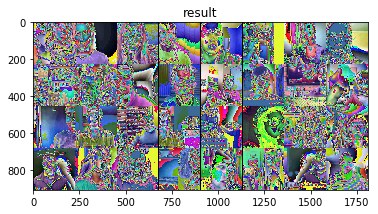

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406])
    #std = np.array([0.229, 0.224, 0.225])
    #inp = std * inp + mean
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, labels = next(iter(dset_loaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title='result')

inputs, labels = Variable(inputs.type(gpu_dtype)), Variable(labels.type(gpu_dtype))
outputs = model(inputs)
loss = criterion(outputs, labels)

for i in range(5):
    print('output',outputs.data[i,0],outputs.data[i,1],outputs.data[i,2],outputs.data[i,3],outputs.data[i,4])
    print('target',labels.data[i,0],labels.data[i,1],labels.data[i,2],labels.data[i,3],labels.data[i,4])
    print ('loss',loss.data[0])
    print (np.sqrt((labels.data[i]-output.data[i])**2))

    print ('---')




In [ ]:
accum_loss = 0
for i in range(32):
    print('output',outputs.data[i,0],outputs.data[i,1],outputs.data[i,2],outputs.data[i,3],outputs.data[i,4])
    print('target',labels.data[i,0],labels.data[i,1],labels.data[i,2],labels.data[i,3],labels.data[i,4])
    l=sum( ((labels.data[i]-outputs.data[i])**2) )
    #print (l  )
    accum_loss += l
    print ('---')
print ('their loss',loss.data[0])
print('my_loss',accum_loss/32)